In [1]:
import numpy as np
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# 1. Human capital accumulation (See problem set 7)

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2 # Notice that this is a very high value of rho
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100) 

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

#### Answer:

**Define initial functions**

In [4]:
# Define utility of consumtion as a function for later use
def utility(c, rho):
    return (c**(1-rho))/(1-rho)

# Define disutility of working for later use 
def disutility(gamma, l):
    return gamma*l

# Define period 2 total utility as a function of rho, gamma, w, b, h2 and l2.
def v2(rho, gamma, w, b, h2, l2):     
    
    # Include the constraint for c1 in the function
    if l2 == 1:
        c2 = w*h2*l2
    else:
        c2 = b
    return utility(c2,rho) - disutility(gamma, l2) # return total utility

# Define total utility in period 1 as a function of rho, gamma, beta, Delta, v2_interp, w, b, h1 and l1
def v1(rho, gamma, beta, Delta, v2_interp, w, b, h1, l1):
    
    # Include the constraint for c1 in the function
    if l1 == 1:
        c1 = w*h1*l1
    else:
        c1 = b
    
    # Include the different cases of capital accumulation
    # Case 1: v2 if low h2
    h2_low = h1 + l1
    v2_low = v2_interp([h2_low])[0]
    
    # Case 2: v2 if high h2
    h2_high = h1 + l1 + Delta
    v2_high = v2_interp([h2_high])[0]
    
    # Calculating the expected value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # Return total utility in period one
    return utility(c1,rho) - disutility(gamma, l1) + beta*v2


**Solving the model in period 2**

In [5]:
# Define the function to solve the model in period two

def get_solution_period_two(rho, gamma, Delta, w, b):
    
    # First we define the grids'. We need the result as a 1*100 vector
    h2_vec = np.linspace(0.1,1.5,100) # Pre-defined vector space
    v2_vec = np.empty(100) # This is just empty for now 
    l2_vec = np.empty(100) # This is just empty for now 
    v2_vec_b = np.empty(100) # to plot the solution with l = 0
    
    # Next, we solve the model for each h2 value in the grid above (all the defined possible values of human capital)
    for i, h2 in enumerate(h2_vec):
        
        # As she decide to work or not to work, we set up an if statement. 
        # She will only work if utility from working is higher than utility from not working.
        
        if v2(rho, gamma, w, b, h2, l2 = 1) > v2(rho, gamma, w, b, h2, l2 = 0): 
            v2_vec[i] = v2(rho, gamma, w, b, h2, l2 = 1) # Calculate utility when working and save it in v2_vec[i]
            l2_vec[i] = 1 # save l2 = 1 to l2_vec[i]
        else:
            v2_vec[i] = v2(rho, gamma, w, b, h2, l2 = 0) # Calculate utility when not working and save it in v2_vec[i]
            l2_vec[i] = 0 # save l2 = 0 to l2_vec[i]
        v2_vec_b[i] = v2(rho, gamma, w, b, h2, l2 = 0) # Get the results for l = 0 and c = b
        
    return h2_vec,v2_vec,l2_vec, v2_vec_b # return the three result vectors

In [6]:
# Solving the model and saving the results
h2_vec,v2_vec,l2_vec, v2_vec_b = get_solution_period_two(rho, gamma, Delta, w, b) 
       
# Construct interpolator to use when calculating v1
v2_interp = interpolate.RegularGridInterpolator((h2_vec,), v2_vec, bounds_error=False,fill_value=None)


We have now solved the model for period 2. Next we plot the results.

#### Plot: Labor supply as a function of human capital

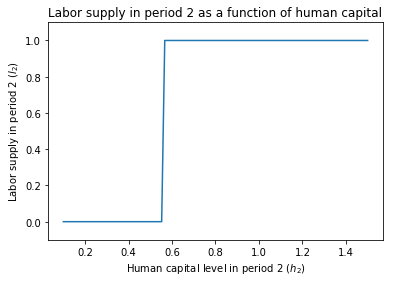

In [7]:
# Plot labor supply as a function of human capital

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h2_vec,l2_vec)
#ax.grid() 
ax.set_xlabel('Human capital level in period 2 ($h_2$)') # 
ax.set_ylabel('Labor supply in period 2 ($l_2$)')
ax.set_title('Labor supply in period 2 as a function of human capital')
ax.set_ylim([-0.1,1.1]); 

From the plot showed above we see that: 
1. The worker will supply zero labor ($l_2 = 0$) in period 2 for human capital levels below 0.57
1. The worker will supply full labor ($l_2 = 1$) in period 2 for human capital levels above 0.57

#### Plot: Utility as a function of labor supply

Text(0.5, 1.0, 'Utility in period 2 by human capital')

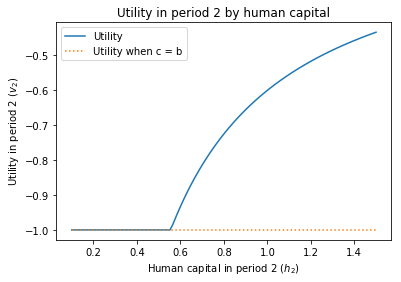

In [8]:
# Plot labor supply as a function of human capital

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h2_vec,v2_vec, label = 'Utility')
ax.plot(h2_vec,v2_vec_b, linestyle= ':', label = 'Utility when c = b')
#ax.grid() 
ax.legend()
ax.set_xlabel('Human capital in period 2 ($h_2$)') # 
ax.set_ylabel('Utility in period 2 ($v_2$)')
ax.set_title('Utility in period 2 by human capital')

Above is the utility in period 2 plottet against different human capital levels. <br>
This result clearly illustrates the trade-off the worker faces, as she:
1. gets a higher consumption when supplying labor, but
1. at the same time gets disutility from working

The worker supplies zero labor up for human capital levels below 0.57 as this maximizes her utility in period two.   <br>
Here, human capital can be seen as productivity meassured on a scale from 0 to 1.5. <br> 
For human capital levels above 0.57 she supplies full labor as this maximizes her utility. <br>
Notice that the obtained utility is below zero for all values of human capital. This is primary due to the high value of $\rho$ in the denominator.

Notice that utility when $c=b$ is when she does not work, i.e.  $l_2=0$

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

In [9]:
# Define the functions to solve the model

def get_solution_period_one(rho, gamma, beta, Delta, v2_interp, w, b):
    
    # first we define the grids'
    h1_vec = np.linspace(0.1,1.5,100)
    v1_vec = np.empty(100) # this is just empty for now 
    l1_vec = np.empty(100) # this is just empty for now 
    v1_vec_b = np.empty(100)
    v1_vec_util1 = np.empty(100)
    
    #next, we solve the model for each h2 value in the grid above
    for i, h1 in enumerate(h1_vec):
        if v1(rho, gamma, beta, Delta, v2_interp, w, b, h1, l1=1) > v1(rho, gamma, beta, Delta, v2_interp, w, b, h1, l1=0): 
            v1_vec[i] = v1(rho, gamma, beta, Delta, v2_interp, h1, w, b, l1 = 1)
            l1_vec[i] = 1
            v1_vec_util1[i] = utility(c = w*h1*1, rho = rho) - disutility(gamma, l = 1)
        else: 
            v1_vec[i] = v1(rho, gamma, beta, Delta, v2_interp, h1, w, b, l1 = 0)
            l1_vec[i] = 0
            v1_vec_util1[i] = utility(c = b, rho = rho)
            
        v1_vec_b[i] = utility(c = b, rho = rho)
        
    return h1_vec,v1_vec,l1_vec, v1_vec_b, v1_vec_util1

In [10]:
# solve period one 
h1_vec,v1_vec,l1_vec, v1_vec_b, v1_vec_util1 = get_solution_period_one(rho, gamma, beta, Delta, v2_interp, w, b)

#### Plot: Labor supply as a function of human capital

Text(0.5, 1.0, 'Labor supply in period 1 as a function of human capital')

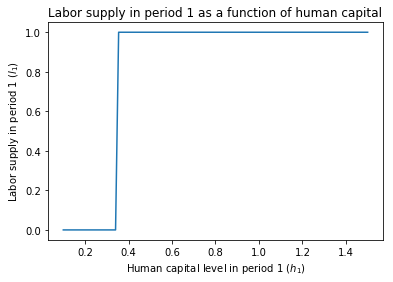

In [11]:
# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h1_vec,l1_vec)
#ax.grid()
ax.set_xlabel('Human capital level in period 1 ($h_1$)') 
ax.set_ylabel('Labor supply in period 1 ($l_1$)')
ax.set_title('Labor supply in period 1 as a function of human capital')

From the results showed above we see that: 
1. The worker will supply zero labor ($l_1 = 0$) for human capital levels below 0.35
1. The worker will supply full labor ($l_1 = 1$) for human capital levels above 0.35

#### Plot: Utility as a function of labor supply

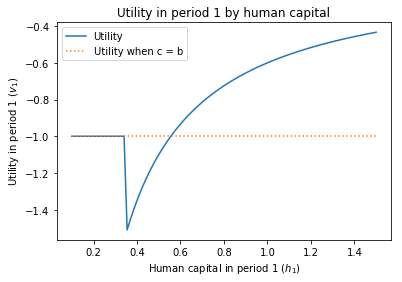

In [12]:
# Plot labor supply as a function of human capital

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h1_vec,v1_vec_util1, label = 'Utility')
ax.plot(h1_vec,v1_vec_b, linestyle= ':', label = 'Utility when c = b')
#ax.grid() 
ax.set_xlabel('Human capital in period 1 ($h_1$)') # 
ax.set_ylabel('Utility in period 1 ($v_1$)')
ax.set_title('Utility in period 1 by human capital')
ax.legend()

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

This can be answered by looking at the two periods as a game solved by backwards induction.
1. In period two she would never supply labor if her potential wage ($wh_2l_2$) is below the unemployment benefits (b) as this is the last period and no more capital accumulation will take place after this period as this is a two period model.
1. In period 1, she will optimize utility with respect to labor where she takes in mind the expected value of utility of period 2.

Given this she will be willing to supply labor even if her potentional wage is lower than the unemployment benefits ($wh_1l_1<b$). Which happens when human capital levels below $h_1 < \frac{b}{wl_1} = 0.5$ <br>
She will be willing to supply labor at these levels because of the possibility of gain (more hunam capital accummutation) in period 2. 


See the figure above for the illustration.

Basically, period 1 is about balancing a trade-off between:
1. Consumption today, and
1. more capital accumulation and thereby consumption in the furture. <br>

For high enough values of expected utility in period 2, she chooses to work even if her potential wage income is lower than the unemployment benefits she can get in period 1.
In our case with she will work start working at a human capital rate at $0.35$ in period 1 earning a potentional wage of $wh_1l_1=2*0.35*1 = 0.7$ even though the outside option is $b=1$.

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [13]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

In [14]:
import numpy as np
from scipy import linalg
from scipy import optimize
import sympy as sm

sm.init_printing(use_unicode=True) # for pretty printing

In [15]:
# Define the parameters and the functions
pi = sm.symbols('pi')
gamma = par['gamma']
phi = par['phi']
y = sm.symbols('y')
y_lag = sm.symbols('y_lag')
pi_lag = sm.symbols('pi_lag')
s = sm.symbols('s')
s_lag = sm.symbols('s_lag')
alpha = par['alpha']
h = par['h']
b = par['b']
v = sm.symbols('v')

In [16]:
AD = (1/(h*alpha))*(v-(1+(b*alpha))*y)
SRAS = pi_lag+gamma*y-phi*gamma*y_lag+s-phi*s_lag

# solve that equation where the SRAS-curve is equal to the AD-curve 
eq = sm.Eq(AD,SRAS)
y_eq = sm.solve(eq,y)[0]
print('Output gap is period t is:')
y_eq

Output gap is period t is:


In [17]:
# insert for y_eq in pi to get equilibrium phi

pi_eq = sm.Eq(pi,SRAS)
pi_eq = sm.solve(pi_eq, pi)[0]
print('Inflation gap in period t is:')
pi_eq 

Inflation gap in period t is:



**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

In [18]:
#Lambdifying the solutions:
y_eq_func = sm.lambdify((pi_lag, s, v), y_eq)
pi_eq_func = sm.lambdify((pi_lag, s, y), pi_eq)

Period 1 without shock:

In [19]:
v = 0

In [20]:
y_eq_func(pi_lag = 0, s = 0, v = v)

In [21]:
pi_eq_func(pi_lag = 0, s = 0, y = y_eq_func(pi_lag = 0, s = 0, v = v))

Period 2 with postive shock:

In [22]:
v = 0.1

In [23]:
y_eq_func(pi_lag = 0, s = 0, v = v)

In [24]:
pi_eq_func(pi_lag = 0, s = 0, y = y_eq_func(pi_lag = 0, s = 0, v = v))

Illustrating:

In [25]:
v = [0, 0.1]
t = range(1, len(v)+1)

output = np.empty(len(t))
inflation = np.empty(len(t))

for i, v in enumerate(v):
    output[i] = y_eq_func(pi_lag = 0, s = 0, v = v)
    inflation[i] = pi_eq_func(pi_lag = 0, s = 0, y = y_eq_func(pi_lag = 0, s = 0, v = v))


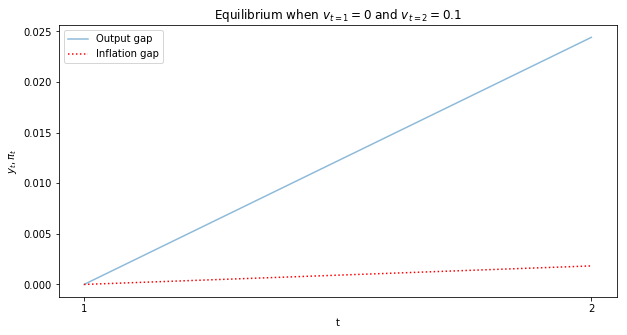

In [26]:
fig = plt.figure(figsize= (10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(t, output, label = 'Output gap', alpha = 0.5)
ax.plot(t, inflation, linestyle= ':', label = 'Inflation gap', color='red')
#ax.grid() 
ax.legend()
ax.set_xlabel('t') # 
ax.set_ylabel('$y_t, \pi_t$')
ax.set_title('Equilibrium when $v_{t=1}=0$ and $v_{t=2}=0.1$')
plt.xticks(t)
plt.show()

We see how a positive demand disturbance in period $t=2$ creates higher output and higher inflation in that period.

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [27]:
par['delta'] = 0.80
par['omega'] = 0.15

delta = par['delta']
omega = par['omega']

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

In [28]:
#Pretty print off
sm.init_printing(pretty_print=False)

In [29]:
#Range to simulate over
t = range(0, 1000, 1)

In [30]:
#Demand shocks
x = [0 for i in t]
x[0] = 0.1

In [31]:
#Supply shocks
c = [0 for i in t]

In [32]:
# Demand and supply disturbances
v = [delta*0+x[0]] #initialisation of v_0
s = [omega*0+c[0]] # initialisation of s_0



for i in range(1, max(t)+1):
    v.append(delta*v[i-1]+x[i])
    s.append(omega*s[i-1]+c[i])

In [33]:
output = [0]
inflation = [0]

for i, j, k in zip(v, s, range(0, 999)):
    output.append(y_eq_func(pi_lag = inflation[k], s = j, v = i))
    inflation.append(pi_eq_func(pi_lag = inflation[k], s = j, y = y_eq_func(pi_lag = inflation[k], s = j, v = i)))

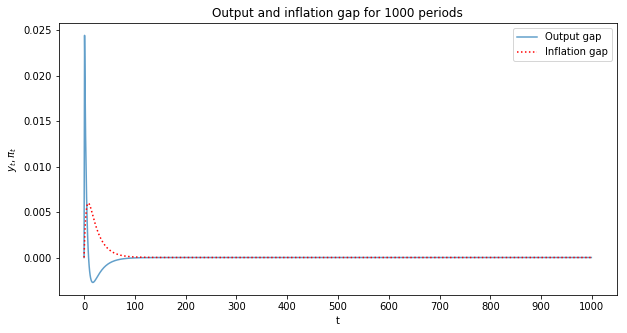

In [34]:
fig = plt.figure(figsize= (10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(t, output, label = 'Output gap', alpha=0.7)
ax.plot(t, inflation, linestyle= ':', label = 'Inflation gap', color='red')
#ax.grid() 
ax.legend()
ax.set_xlabel('t') # 
ax.set_ylabel('$y_t, \pi_t$')
ax.set_title('Output and inflation gap for 1000 periods')
plt.xticks(range(0, 1001, 100))
plt.show()

bla bla

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [35]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

sigma_x = par['sigma_x']
sigma_c = par['sigma_c']

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

We need define a simulation function - one which takes in $\sigma_x$, $\sigma_c$ and $\phi$ so we can use it for question 4 and 5.

First, we need to solve the model with these parameters as choice inputs with same procedure as before:

In [36]:
# Define the parameters and the functions
pi = sm.symbols('pi')
gamma = par['gamma']
phi = sm.symbols('phi')
y = sm.symbols('y')
y_lag = sm.symbols('y_lag')
pi_lag = sm.symbols('pi_lag')
s = sm.symbols('s')
s_lag = sm.symbols('s_lag')
alpha = par['alpha']
h = par['h']
b = par['b']
v = sm.symbols('v')

In [37]:
AD = (1/(h*alpha))*(v-(1+(b*alpha))*y)
SRAS = pi_lag+gamma*y-phi*gamma*y_lag+s-phi*s_lag

# solve that equation where the SRAS-curve is equal to the AD-curve 
eq = sm.Eq(AD,SRAS)
y_eq = sm.solve(eq,y)[0]
print('Output gap is period t is:')
y_eq

Output gap is period t is:


0.703125*phi*s_lag + 0.052734375*phi*y_lag - 0.703125*pi_lag - 0.703125*s + 0.244140625*v

In [38]:
# insert for y_eq in pi to get equilibrium phi

pi_eq = sm.Eq(pi,SRAS)
pi_eq = sm.solve(pi_eq, pi)[0]
print('Inflation gap in period t is:')
pi_eq 

Inflation gap in period t is:


-phi*s_lag - 0.075*phi*y_lag + pi_lag + s + 0.075*y

In [39]:
#Lambdifying the solutions:
y_eq_func = sm.lambdify((pi_lag, s, v, phi, s_lag, y_lag), y_eq)
pi_eq_func = sm.lambdify((pi_lag, s, y, phi, s_lag, y_lag), pi_eq)

Now, we can contruct a simulation function for a 1000 periods:

In [40]:
def simulate(sigma_x, sigma_c, phi):
    #Range to simulate over
    t = range(0, 1000, 1)
    
    #Seed - need this in order to use the function over multiple samples for changed parameters
    np.random.seed(32)
    #Demand shocks    
    x = [np.random.normal(0, sigma_x) for i in t]
    
    #Supply shocks
    c = [np.random.normal(0, sigma_c) for i in t]
    
    # Demand and supply disturbances
    v = [delta*0+x[0]] #initialisation of v_0
    s = [omega*0+c[0]] # initialisation of s_0

    for i in range(1, max(t)+1):
        v.append(delta*v[i-1]+x[i])
        s.append(omega*s[i-1]+c[i])
        
    output = [0]
    inflation = [0]

    for i, j, k in zip(v, s, range(0, 999)):
        output.append(y_eq_func(pi_lag = inflation[k], s = j, v = i, phi = phi, s_lag = s[k], y_lag = output[k]))
        inflation.append(pi_eq_func(pi_lag = inflation[k], s = j,
                                    y =y_eq_func(pi_lag = inflation[k], s = j, v = i, phi = phi, s_lag = s[k], y_lag = output[k]),
                                    phi = phi, s_lag = s[k], y_lag = output[k]))
        
    def autocorr(x, t=1):
        return np.corrcoef(np.array([x[:-t], x[t:]]))
    
    var_output = np.var(output)
    var_inflation = np.var(inflation)
    corr_output_inflation = np.corrcoef(output, inflation)[1][0]
    acf_output = autocorr(output)[1][0]
    acf_inflation = autocorr(inflation)[1][0]
    
    return output, inflation, var_output, var_inflation, corr_output_inflation, acf_output, acf_inflation

In [41]:
output = simulate(sigma_x=3.492, sigma_c=0.2, phi = 0.1)[0]
inflation = simulate(sigma_x=3.492, sigma_c=0.2, phi = 0.1)[1]

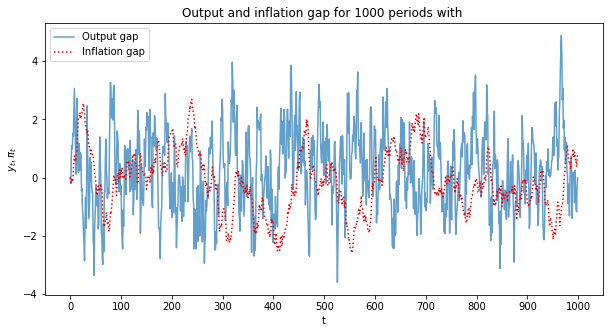

In [42]:
fig = plt.figure(figsize= (10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(t, output, label = 'Output gap', alpha=0.7)
ax.plot(t, inflation, linestyle= ':', label = 'Inflation gap', color='red')
#ax.grid() 
ax.legend()
ax.set_xlabel('t') # 
ax.set_ylabel('$y_t, \pi_t$')
ax.set_title('Output and inflation gap for 1000 periods with ')
plt.xticks(range(0, 1001, 100))
plt.show()

Bla bla bla ....

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

We use our simulation function to loop over certain values in the interval for $\phi\in(0,1)$ and plot the correlation between output gap and inflation gap.

In [43]:
corr_output_inflation = []
phi_range = np.linspace(0,1,21)

for i in phi_range:
    corr_output_inflation.append(simulate(sigma_x = 3.492, sigma_c = 0.2, phi = i)[4])

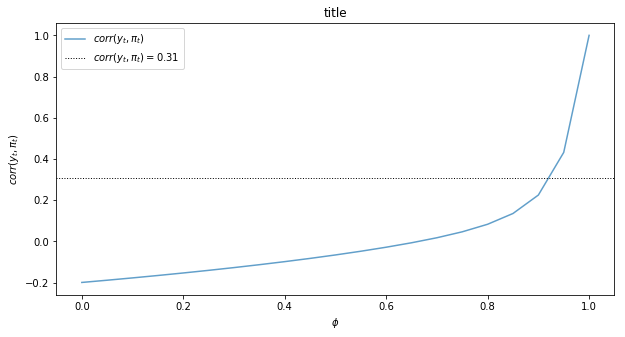

In [44]:
fig = plt.figure(figsize= (10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(phi_range, corr_output_inflation, label = '$corr(y_t,\pi_t)$', alpha=0.7)
#ax.grid() 
ax.legend()
ax.set_xlabel('$\phi$')  
ax.set_ylabel('$corr(y_t,\pi_t)$')
ax.set_title('title')
#plt.xticks(range(0, 1.1))
plt.axhline(y=0.31, color = 'black', linewidth = 1, linestyle =':', label = '$corr(y_t,\pi_t)=0.31$')
plt.legend()
plt.show()

The figure gives a pretty good indication of what value of $\phi$ results in $corr(y_t,\pi_t)=0.31$.

However, in order to get a better estimate, we use numerical optimization:

We may need to change simulation function to only have 1 output of corr??

In [350]:
x0 = np.array([0.5, 0.5, 0.5])
optimize.minimize(simulate(sigma_x = 3.492, sigma_c = 0.2), x0=x0, )

TypeError: simulate() missing 1 required positional argument: 'phi'

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy (Problem set 2)

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [271]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

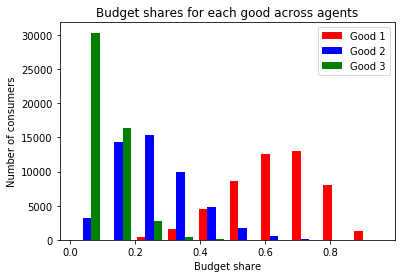

In [272]:
# Histogram of the budget shares for each of the three goods
colors = ['red', 'blue', 'green'] # define colors
plt.hist(betas, bins = 10, color=colors, label=['Good 1', 'Good 2', 'Good 3']) #create histogram from array of betas
plt.title('Budget shares for each good across agents') # title
plt.xlabel('Budget share') #xlabel
plt.ylabel('Number of consumers') #ylabel
plt.legend() # add legend

We see that good number one has the highest budget shares, which indicates that this is the most valuable good. <br>
Further good three has the lowest budget shares.


Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

In [273]:
# Save the values of beta1, beta2, beta3 across agents respectively
betas_good_one = [x[0] for x in betas]
betas_good_two = [x[1] for x in betas]
betas_good_three = [x[2] for x in betas]

In [274]:
#Define demand function for each good

def demand_func(betas,p1,p2,p3,e1,e2,e3, good):
    if good == 1:
        betas_good_one = [x[0] for x in betas]
        I = p1*e1+p2*e2+p3*e3
        return betas_good_one*I/p1
    if good == 2:
        betas_good_two = [x[1] for x in betas]
        I = p1*e1+p2*e2+p3*e3
        return betas_good_two*I/p2

    if good == 3:
        betas_good_three = [x[2] for x in betas]
        I = p1*e1+p2*e2+p3*e3
        return betas_good_three*I/p3

In [275]:
# Define excess demand function for each good 
def excess_demand_func(alphas,p1,p2, p3,e1,e2, e3, good):
    
    # a. demand
    demand = np.sum(demand_func(betas,p1,p2,p3,e1,e2,e3, good))
    
    # b. supply (depend on the good)
    if good == 1:
        supply = np.sum(e1)
    if good == 2:
        supply = np.sum(e2)
    if good == 3:
        supply = np.sum(e3) 
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

In [276]:
# plot the excess demand function 

# create x values
prices_good_one = prices_good_two = prices_good_three = np.linspace(0,2,18)

# create inital values and empty lists
excess_demand_good_one = []
excess_demand_good_two = [] 
excess_demand_good_three = [] 
p1 = 1
p2 = 1
p3 = 1

# Obtain the excess demand for each good
for num in prices_good_one:
    excess_demand_good_one.append(excess_demand_func(alphas,num,p2,p3,e1,e2,e3, good = 1))
    
for num in prices_good_two:
    excess_demand_good_two.append(excess_demand_func(alphas,p1, num,p3,e1,e2,e3, good = 2))
    
for num in prices_good_three:
    excess_demand_good_three.append(excess_demand_func(alphas,p1,p2,num,e1,e2,e3, good = 3))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


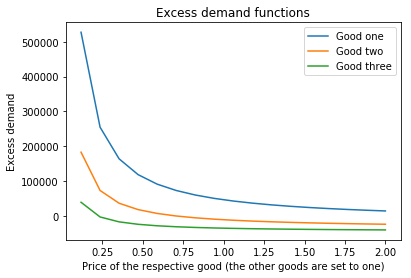

In [277]:
# plot the result

plt.plot(prices_good_one, excess_demand_good_one, label = 'Good one')
plt.plot(prices_good_one, excess_demand_good_two, label = 'Good two')
plt.plot(prices_good_one, excess_demand_good_three, label = 'Good three')
plt.legend() # set legend
plt.title('Excess demand functions') # title
plt.xlabel('Price of the respective good (the other goods are set to one)') #xlabel
plt.ylabel('Excess demand') #ylabel
plt.show()

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

In [278]:
def find_equilibrium(betas,p1,p2, p3,e1,e2, e3,kappa=0.5,eps=1e-8,maxiter=700):
    
    t = 0
    while True:

        # a. step 1: excess demand
        Z1 = excess_demand_good_1_func(betas,p1,p2,p3,e1,e2,e3)
        Z2 = excess_demand_good_2_func(betas,p1,p2,p3,e1,e2,e3)
        
        # b: step 2: stop?
        if  (np.abs(Z1) < eps and np.abs(Z2) < eps) or t >= maxiter:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
            print(f'{t:3d}: p2 = {p2:12.8f} -> excess demand -> {Z1:14.8f}')
            break    
    
        # c. step 3: update p1
        p1 = p1 + kappa*Z1/betas.size
        p2 = p2 + kappa*Z2/betas.size
            
        # d. step 4: return 
        if t < 5 or t%25 == 0:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
            print(f'{t:3d}: p2 = {p2:12.8f} -> excess demand -> {Z2:14.8f}')
        elif t == 5:
            print('   ...')
            
        t += 1    

    return p1, p2

In [279]:
# Set initial values
p1 = 1.4
p2 = 1
p3 = 1
kappa = 0.5
eps = 1e-8
p1,p2 = find_equilibrium(betas,p1,p2, p3,e1,e2, e3,kappa=kappa,eps=eps)

  0: p1 =   1.37973738 -> excess demand -> -6078.78547887
  0: p2 =   0.97973738 -> excess demand -> -6078.78547887
  1: p1 =   1.36072543 -> excess demand -> -5703.58688816
  1: p2 =   0.96072543 -> excess demand -> -5703.58688816
  2: p1 =   1.34293491 -> excess demand -> -5337.15508587
  2: p2 =   0.94293491 -> excess demand -> -5337.15508587
  3: p1 =   1.32633197 -> excess demand -> -4980.88210779
  3: p2 =   0.92633197 -> excess demand -> -4980.88210779
  4: p1 =   1.31087848 -> excess demand -> -4636.04661785
  4: p2 =   0.91087848 -> excess demand -> -4636.04661785
   ...
 25: p1 =   1.16728913 -> excess demand ->  -642.43316291
 25: p2 =   0.76728913 -> excess demand ->  -642.43316291
 50: p1 =   1.15010462 -> excess demand ->   -39.17243132
 50: p2 =   0.75010462 -> excess demand ->   -39.17243132
 75: p1 =   1.14908447 -> excess demand ->    -2.27040386
 75: p2 =   0.74908447 -> excess demand ->    -2.27040386
100: p1 =   1.14902544 -> excess demand ->    -0.13119037
100: p2

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

In [280]:
# Define utility function

def utility(p1,p2,p3, e1,e2, e3 ,betas, gamma):
    
    # retrive the demands for each good
    x1 = demand_good_1_func(betas,p1,p2,p3,e1,e2,e3)
    x2 = demand_good_2_func(betas,p1,p2,p3,e1,e2,e3)
    x3 = demand_good_3_func(betas,p1,p2,p3,e1,e2,e3)
    
    # save the beta values
    betas_good_one = np.array([x[0] for x in betas])
    betas_good_two = np.array([x[1] for x in betas])
    betas_good_three = np.array([x[2] for x in betas])
    
    # return the utility for each consumer
    return ((x1**betas_good_one)*(x2**betas_good_two)*(x3**betas_good_three))**gamma
    

In [281]:
# Set values. Here p1 and p2 is equal to the optimal value from question 3.
# p3 is set to one

p1 = 1.14686375
p2 = 0.74686375
p3 = 1

In [282]:
utility_result = utility(p1,p2,p3, e1,e2, e3,betas, gamma)

Text(0, 0.5, 'Number of consumers')

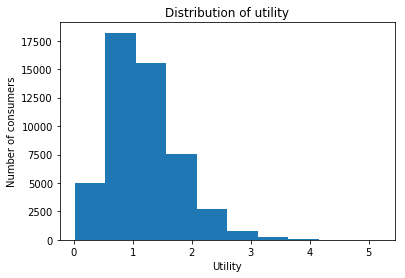

In [283]:
# plot the results
plt.hist(utility_result, bins = 10) # Set the number of bins to 10
plt.title('Distribution of utility') # title
plt.xlabel('Utility') #xlabel
plt.ylabel('Number of consumers') #ylabel

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

In [284]:
# set endowment for each good to one
e1 = e2 = e3 = np.full((50000), 1)

In [285]:
# Set values. Here p1 and p2 is equal to the optimal value from question 3.
# p3 is set to one

p1 = 1.14686375
p2 = 0.74686375
p3 = 1

In [313]:
utility_result_new = utility(p1,p2,p3, e1,e2, e3,betas, gamma)
utility_result_new_gamma_high = utility(p1,p2,p3, e1,e2, e3,betas, gamma = 2)

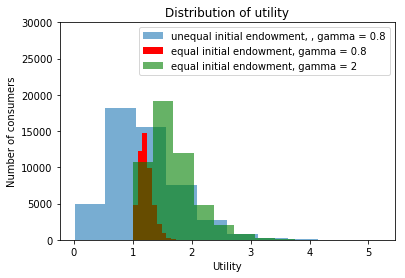

In [316]:
# plot the results
plt.hist(utility_result, bins = 10, alpha = 0.6, label = 'unequal initial endowment, , gamma = 0.8') # Set the number of bins to 10
plt.hist(utility_result_new, bins = 10, alpha = 1, color = 'red', label = 'equal initial endowment, gamma = 0.8') # Set the number of bins to 10
plt.hist(utility_result_new_gamma_high, bins = 10, alpha = 0.6, color = 'green', label = 'equal initial endowment, gamma = 2') # Set the number of bins to 10

plt.title('Distribution of utility') # title
plt.xlabel('Utility') #xlabel
plt.ylabel('Number of consumers') #ylabel
plt.ylim([0,30000])
plt.legend() # add legend

Result: 